# UCI HAR Dataset

## Data reading and processing

In [1]:
import pandas as pd
import os

# Setup the data directory paths
data_dir = 'data/human activity recognition using smartphones/UCI HAR Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Load the datasets
train_set = pd.read_table(os.path.join(train_dir, 'X_train.txt'), delim_whitespace=True, header=None)
train_labels = pd.read_table(os.path.join(train_dir, 'y_train.txt'), delim_whitespace=True, header=None)
train_clients = pd.read_table(os.path.join(train_dir, 'subject_train.txt'), delim_whitespace=True, header=None)

test_set = pd.read_table(os.path.join(test_dir, 'X_test.txt'), delim_whitespace=True, header=None)
test_labels = pd.read_table(os.path.join(test_dir, 'y_test.txt'), delim_whitespace=True, header=None)
test_clients = pd.read_table(os.path.join(test_dir, 'subject_test.txt'), delim_whitespace=True, header=None)

In [2]:
df_conc = pd.DataFrame({"Clients":train_clients[0],
                        "labels": train_labels[0]})
print(df_conc.shape)
df_conc = pd.concat([df_conc, train_set], axis=1)
print(df_conc.shape)

(7352, 2)
(7352, 563)


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

def split_data(data_set, labels, clients, test_size_ratio, no_clients):
    """
    Splits data into training and testing sets for each client.

    :param data_set: The input data set.
    :param labels: The labels corresponding to the input data set.
    :param clients: The client IDs for each data point.
    :param test_size_ratio: The ratio of the test set size to the original data set size.
    :param no_clients: The number of clients.

    :return: Four lists containing the training and testing sets for each client:
             x_train - input data for training,
             y_train - corresponding labels for training,
             x_test - input data for testing,
             y_test - corresponding labels for testing.
    """
    x_train, y_train = [], []
    x_test, y_test = [], []

    for t in range(no_clients):
        idx = clients[clients[0] == (t + 1)].index
        client_data = data_set.iloc[idx].values
        client_labels = labels.iloc[idx].values.squeeze()

        # Split data for the current client
        x_train_client, x_test_client, y_train_client, y_test_client = train_test_split(
            client_data, client_labels, test_size=test_size_ratio, random_state=42
        )

        # Append data for the current client to the overall training and testing sets
        x_train.append(x_train_client)
        y_train.append(y_train_client)
        x_test.append(x_test_client)
        y_test.append(y_test_client)

    return x_train, y_train, x_test, y_test

## Comparison

### Local vs Gloabl vs MTL Experiment

In [37]:
# same as original experiments
opts = {
    "obj":"C",
    "sys_het":False,
    "avg": True,
    "top":1,
    "bottom":0.1,
    "mocha_outer_iters":1,
    "mocha_inner_iters":20,
    "mocha_sdca_frac":1,
    "update":1,
    "mbsgd_outer_iters":1,
    "mbsgd_inner_iters":50,
    "mbsgd_sgd_frac":0.5,
    "mbsgd_scaling":0.1,
    "max_sdca_iters":10
}

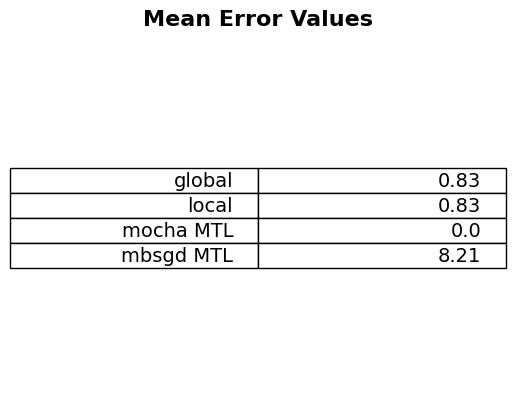

In [38]:
from opt.mocha import run_mocha
from opt.mbsgd import run_mbsgd
from opt.baseline import local_model,global_model
import matplotlib.pyplot as plt

def run_trails(set, labels, clients, n_trails=10):
    """
    :param set: The dataset used for training and testing.
    :param labels: The labels corresponding to the dataset.
    :param clients: The list of clients representing the partitioned data.
    :param n_trails: The number of times to repeat the training and testing process. Defaults to 10.
    :return: When successful, returns the mean error values for different models. Otherwise, returns the error values for each trial.

    """
     lambda_values = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10]
     
    
     best_local=[]
     best_global=[]
     best_mbsdg_mtl=[]
     best_mocha_mtl=[]
     for _ in range(n_trails):
         Xtrain, ytrain, Xtest, ytest = split_data(set, labels, clients, 0.25, 30)
         err_local=[]
         err_global=[]
         err_mbsdg_mtl=[]
         err_mocha_mtl=[]
         for lambda_ in lambda_values:
             err_local.append(local_model(Xtrain, ytrain , Xtest, ytest, lambda_, opts) )
             err_global.append(global_model(Xtrain, ytrain , Xtest, ytest, lambda_, opts))
             rmse, _, _, _ = run_mocha( Xtrain, ytrain, Xtest, ytest, lambda_, problem_type='C',opts=opts )
             err_mocha_mtl.append(rmse[-1])
             rmse,_, _ = run_mbsgd( Xtrain, ytrain, Xtest, ytest, lambda_,opts=opts )
             err_mbsdg_mtl.append(rmse[-1])
        
         try:
             best_local.append(min(err_local))
             best_global.append(min(err_global))
             best_mocha_mtl.append(min(err_mocha_mtl))
             best_mbsdg_mtl.append(min(err_mbsdg_mtl))
         except:
             return err_global, err_local, err_mbsdg_mtl, err_mocha_mtl
    
    
         try:
             mean_values = {"global":round(np.mean(best_global),2), 
                            "local": round(np.mean(best_local),2), 
                            "mocha MTL":round(np.mean(best_mocha_mtl),2), 
                            "mbsgd MTL" : round(np.mean(best_mbsdg_mtl),2)}
         except:
             return best_local, best_global, best_mbsdg_mtl, best_mocha_mtl
   
     
     
     fig, ax = plt.subplots()
    # turn off axis
     plt.axis('off')
    # title of the table
     ax.set_title('Mean Error Values', fontsize=16, weight='bold')
    
     table_data=[]
     for key, value in mean_values.items():
         table_data.append([key, value])
    
     table = ax.table(cellText=table_data, loc='center')
    
     table.auto_set_font_size(False)
     table.set_fontsize(14)
    # setup layout
     table.scale(1, 1.5)
     plt.show()
     

run_trails(pd.concat([train_set, test_set]), pd.concat([train_labels, test_labels]), pd.concat([train_clients, test_clients]))
         